In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import brentq, minimize
from scipy.stats import norm

# pd.set_option("display.max_rows", None)

In [2]:
options = pd.read_csv(r"data\cleaned_options_data.csv")

# Step 1: Convert the 'ts_recv' column to datetime (this is already optimized)
options["datetime"] = pd.to_datetime(options["ts_recv"], format="%Y-%m-%dT%H:%M:%S.%fZ")

# Step 2: Vectorized parsing of the 'symbol' column
# Split by spaces and extract the relevant parts directly
symbol_parts = options["symbol"].str.split(" ", expand=True)[
    3
]  # Get the fourth part (index 3)

# Extract expiration date (first 6 characters)
options["exp_date"] = pd.to_datetime(symbol_parts.str[:6], format="%y%m%d")

# Extract action ('C' or 'P', at index 6)
options["action"] = symbol_parts.str[6]

# Extract strike price (from index 7 onward, divided by 1000)
options["strike_price"] = symbol_parts.str[7:].astype(float) / 1000

# Step 3: Rename the other columns as needed
options = options.rename(
    columns={
        "bid_px_00": "bidp",
        "ask_px_00": "askp",
        "bid_sz_00": "bid_sz",
        "ask_sz_00": "ask_sz",
    }
)
options["datetime"] = (
    pd.to_datetime(options["datetime"])
    .dt.tz_localize("UTC")
    .dt.tz_convert("US/Eastern")
    .dt.tz_localize(None)
)
options["date"] = options["datetime"].dt.date

# Calculate 'till_exp' (time to expiration in years)
options["till_exp"] = (options["exp_date"] - options["datetime"]).dt.days / 365.0

# Calculate 'fair_value' as the average of bid and ask price
options["fair_value"] = (options["bidp"] + options["askp"]) / 2.0

In [3]:
underlying = pd.read_csv(r"data\spx_minute_level_data_jan_mar_2024.csv")
underlying = underlying.loc[underlying["price"] > 0]
underlying["date"] = pd.to_datetime(underlying["date"], format="%Y%m%d")

underlying = (
    underlying.groupby("date")
    .agg(
        Open=("price", "first"),
        High=("price", "max"),
        Low=("price", "min"),
        Close=("price", "last"),
    )
    .reset_index()
)

In [4]:
indices = underlying["date"].searchsorted(options["datetime"])
indices = indices.clip(0, len(underlying) - 1)
options["underlying"] = underlying["Close"].iloc[indices].values

In [5]:
# For calls, I want difference to be as high as possible
# For puts, I want difference to be as negative as possible
options["deviate"] = options["underlying"] - options["strike_price"]

# Make options["deviate"] negative for calls
options.loc[options["action"] == "C", "deviate"] *= -1

In [6]:
min_exp_date_per_group = options.groupby(["date", "action"])["exp_date"].transform(
    "min"
)
result = options[options["exp_date"] == min_exp_date_per_group]
indices = result.groupby(["date", "action", "exp_date"])["deviate"].idxmin()
result = result.loc[indices].reset_index(drop=True)

In [7]:
indices = underlying["date"].searchsorted(result["exp_date"])
indices = indices.clip(0, len(underlying) - 1)
exp_underlyings = underlying["Close"].iloc[indices].values

TODO Make sure to check for:

- Expiration date is before end of interval
- Both call and put exist and have same expiration date
- Deviations from the underlying is below some threshold


In [8]:
profits = []
for i in range(0, len(result), 2):
    ccall = result.iloc[i]  # First row (Call)
    cput = result.iloc[i + 1]  # Second row (Put)

    # Calculate values based on the given formula
    exp_price = exp_underlyings[i]
    underlying_cost = ccall["askp"] + cput["askp"]
    call_profit = 100 * (exp_price - ccall["strike_price"])
    put_profit = 100 * (cput["strike_price"] - exp_price)
    overall_profit = max(call_profit, 0) + max(put_profit, 0) - underlying_cost

    # Store the calculated profit
    profits.append((ccall["datetime"], overall_profit))

In [9]:
result.columns

Index(['ts_recv', 'instrument_id', 'bidp', 'askp', 'bid_sz', 'ask_sz',
       'symbol', 'datetime', 'exp_date', 'action', 'strike_price', 'date',
       'till_exp', 'fair_value', 'underlying', 'deviate'],
      dtype='object')

In [13]:
orders = pd.DataFrame(columns=["datetime", "option_symbol", "action", "order_size"])
for i in range(0, len(result), 2):
    ccall = result.iloc[i]  # First row (Call)
    cput = result.iloc[i + 1]  # Second row (Put)

    # IF SOME CONDITION
    if (
        (ccall["exp_date"] >= datetime(2024, 3, 31))
        or (max(ccall["deviate"], cput["deviate"]) > 3.0)
        or (ccall["exp_date"] != cput["exp_date"])
    ):
        continue
    order_size = min(ccall["bid_sz"], cput["bid_sz"])
    new_rows = pd.DataFrame(
        [
            {
                "datetime": ccall["ts_recv"],  # ts_recv for the Call option
                "option_symbol": ccall["symbol"],  # Use the Call option symbol
                "action": "S",  # Action for the Call option
                "order_size": order_size,  # Minimum ask size
            },
            {
                "datetime": cput["ts_recv"],  # ts_recv for the Call option
                "option_symbol": cput["symbol"],  # Use the Call option symbol
                "action": "S",  # Action for the Call option
                "order_size": order_size,  # Minimum ask size
            },
        ]
    )
    orders = pd.concat(
        [orders, new_rows],
        ignore_index=True,
    )

# Backtesting Code


In [14]:
from datetime import datetime
from backtester import Backtester
from feed_strategy import Strategy

start = datetime(2024, 1, 1)
end = datetime(2024, 3, 30)
s = Strategy(orders)
b = Backtester(start, end, s)

In [15]:
b.calculate_pnl()

2024-01-01 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-02 00:00:00 capital: 60409131.271874994 portfolio value: 39841536.328125 total pnl: 100250667.6 open orders: 2
2024-01-03 00:00:00 capital: 22079948.972656243 portfolio value: 78415565.52734375 total pnl: 100495514.5 open orders: 4
2024-01-04 00:00:00 capital: 1643676.8132812418 portfolio value: 99050246.38671875 total pnl: 100693923.19999999 open orders: 5
2024-01-05 00:00:00 capital: 1643676.8132812418 portfolio value: 99050246.38671875 total pnl: 100693923.19999999 open orders: 5
2024-01-06 00:00:00 capital: 1643676.8132812418 portfolio value: 99050246.38671875 total pnl: 100693923.19999999 open orders: 5
2024-01-07 00:00:00 capital: 1643676.8132812418 portfolio value: 99050246.38671875 total pnl: 100693923.19999999 open orders: 5
2024-01-08 00:00:00 capital: 1643676.8132812418 portfolio value: 99050246.38671875 total pnl: 100693923.19999999 open orders: 5
2024-01-09 00:00:00 capita

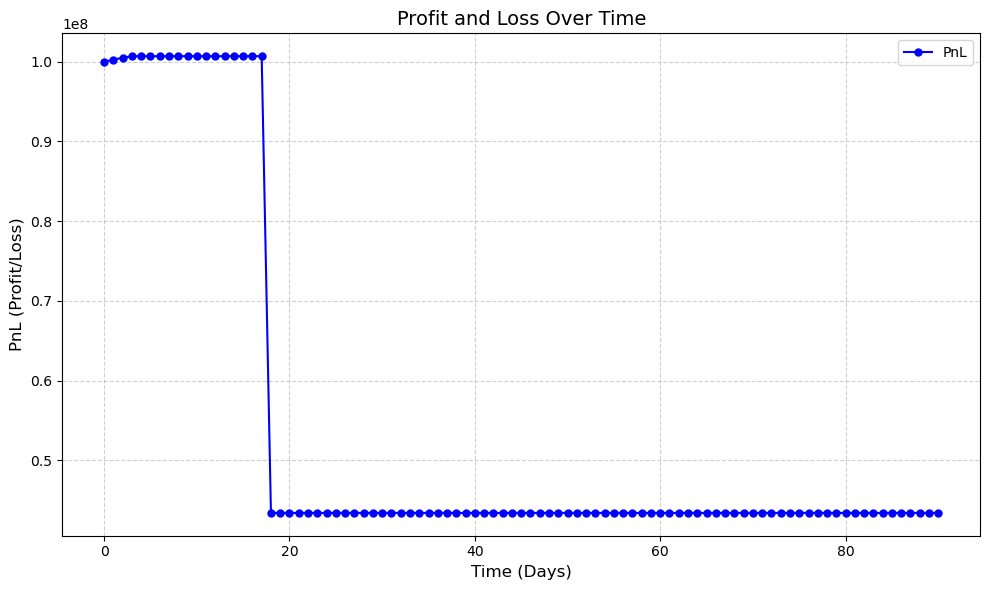

In [16]:
b.plot_pnl()

In [17]:
b.compute_overall_score()

Max Drawdown: 0.5690756880058367
Overall Return: -56.60854042304688%
Sharpe Ratio: -0.10611657081215173
Cannot calculate overall score (Max Drawdown or Sharpe Ratio <= 0)
